In [ ]:
#Step 0
!pip install --quiet torch torchvision nltk sacrebleu tqdm matplotlib

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

import torch
print("Torch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Torch version: 2.8.0+cu126
Device: cuda


In [ ]:
#Step 1
import os, zipfile, urllib.request, re, random, math, time, json
from pathlib import Path
from collections import Counter
from tqdm.auto import tqdm

DATA_DIR = Path("cornell_data")
DATA_DIR.mkdir(exist_ok=True)
ZIP_PATH = DATA_DIR / "cornell_movie_dialogs_corpus.zip"

if not ZIP_PATH.exists():
    print("Downloading Cornell Movie-Dialogs Corpus...")
    urllib.request.urlretrieve(
        "http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip",
        str(ZIP_PATH)
    )
    print("Downloaded.")

with zipfile.ZipFile(str(ZIP_PATH), 'r') as z:
    z.extractall(str(DATA_DIR))

LINES_FILE = DATA_DIR / "cornell movie-dialogs corpus" / "movie_lines.txt"
CONVS_FILE = DATA_DIR / "cornell movie-dialogs corpus" / "movie_conversations.txt"
print("Lines exists:", LINES_FILE.exists())
print("Convs exists:", CONVS_FILE.exists())

Downloaded.
Lines exists: True
Convs exists: True


In [ ]:
#Step 2
import nltk
def clean_text(s):
    s = s.lower()
    s = re.sub(r"[^a-z0-9?.!,'\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# read lines
id2line = {}
with open(LINES_FILE, encoding='iso-8859-1') as f:
    for line in f:
        parts = line.strip().split(" +++$+++ ")
        if len(parts) == 5:
            id2line[parts[0]] = parts[4]

pairs = []
with open(CONVS_FILE, encoding='iso-8859-1') as f:
    for line in f:
        parts = line.strip().split(" +++$+++ ")
        if len(parts) == 4:
            line_ids = eval(parts[3])
            for i in range(len(line_ids)-1):
                a = id2line.get(line_ids[i], "").strip()
                b = id2line.get(line_ids[i+1], "").strip()
                if a and b:
                    pairs.append((clean_text(a), clean_text(b)))

print("Total raw pairs:", len(pairs))

# filter by token length
pairs = [(a,b) for a,b in pairs if len(nltk.word_tokenize(a))<=20 and len(nltk.word_tokenize(b))<=20]
print("Filtered pairs (<=20 tokens each):", len(pairs))
MAX_PAIRS = 60000
if len(pairs) > MAX_PAIRS:
    pairs = random.sample(pairs, k=MAX_PAIRS)
    print("Subsampled pairs to:", len(pairs))

Total raw pairs: 221282
Filtered pairs (<=20 tokens each): 148621
Subsampled pairs to: 60000


In [ ]:
#Step 3: vocab, encodings, dataloaders
from torch.utils.data import Dataset, DataLoader, random_split
import torch
PAD, SOS, EOS, UNK = "<PAD>", "<SOS>", "<EOS>", "<UNK>"


counter = Counter()
for a,b in pairs:
    counter.update(nltk.word_tokenize(a))
    counter.update(nltk.word_tokenize(b))

MAX_VOCAB = 20000
most_common = [w for w,_ in counter.most_common(MAX_VOCAB)]
vocab = [PAD, SOS, EOS, UNK] + most_common
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for w,i in word2idx.items()}
vocab_size = len(vocab)
print("Vocab size:", vocab_size)

MAX_LEN = 20

def encode_sentence(s):
    toks = nltk.word_tokenize(s)[:(MAX_LEN-2)]
    ids = [word2idx.get(t, word2idx[UNK]) for t in toks]
    return [word2idx[SOS]] + ids + [word2idx[EOS]]

def pad_sequence(ids, max_len=MAX_LEN):
    ids = ids[:max_len]
    ids = ids + [word2idx[PAD]]*(max_len - len(ids))
    return ids

class MoviePairsDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        s,t = self.pairs[idx]
        s_ids = torch.tensor(pad_sequence(encode_sentence(s)), dtype=torch.long)
        t_ids = torch.tensor(pad_sequence(encode_sentence(t)), dtype=torch.long)
        return s_ids, t_ids

dataset = MoviePairsDataset(pairs)
train_n = int(0.8*len(dataset))
val_n = int(0.1*len(dataset))
test_n = len(dataset)-train_n-val_n
train_set, val_set, test_set = random_split(dataset, [train_n, val_n, test_n])
BATCH = 128
train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=BATCH, drop_last=False)
test_loader = DataLoader(test_set, batch_size=BATCH, drop_last=False)
print("Train/Val/Test sizes:", len(train_set), len(val_set), len(test_set))

Vocab size: 20004
Train/Val/Test sizes: 48000 6000 6000


In [ ]:
#Step 4 Models
import torch.nn as nn
import math

EMB = 256
HID = 512


def make_embedding(vocab_size, emb_dim=EMB):
    return nn.Embedding(vocab_size, emb_dim, padding_idx=word2idx[PAD])

# ---- ANN (MLP) model:
class MLPSeq(nn.Module):
    def __init__(self, vocab_size, emb_size=EMB, hidden=1024):
        super().__init__()
        self.embedding = make_embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*MAX_LEN, hidden)
        self.fc2 = nn.Linear(hidden, vocab_size*MAX_LEN)
    def forward(self, src):
        emb = self.embedding(src).view(src.size(0), -1)
        h = torch.relu(self.fc1(emb))
        out = self.fc2(h).view(src.size(0), MAX_LEN, -1)
        return out

# ---- RNN/LSTM/GRU Seq2Seq
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, emb_size=EMB, hid_size=HID, n_layers=1, cell='gru'):
        super().__init__()
        self.embedding = make_embedding(vocab_size, emb_size)
        if cell=='lstm':
            self.rnn = nn.LSTM(emb_size, hid_size, num_layers=n_layers, batch_first=True)
        elif cell=='rnn':
            self.rnn = nn.RNN(emb_size, hid_size, num_layers=n_layers, batch_first=True)
        else:
            self.rnn = nn.GRU(emb_size, hid_size, num_layers=n_layers, batch_first=True)
    def forward(self, src):
        emb = self.embedding(src)
        outputs, hidden = self.rnn(emb)
        return hidden

class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, emb_size=EMB, hid_size=HID, n_layers=1, cell='gru'):
        super().__init__()
        self.embedding = make_embedding(vocab_size, emb_size)
        if cell=='lstm':
            self.rnn = nn.LSTM(emb_size, hid_size, num_layers=n_layers, batch_first=True)
        elif cell=='rnn':
            self.rnn = nn.RNN(emb_size, hid_size, num_layers=n_layers, batch_first=True)
        else:
            self.rnn = nn.GRU(emb_size, hid_size, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hid_size, vocab_size)
    def forward(self, input_tok, hidden):
        # input_tok: B x 1
        emb = self.embedding(input_tok)  # B x 1 x E
        out, hidden = self.rnn(emb, hidden)
        logits = self.fc(out.squeeze(1))
        return logits, hidden

class Seq2SeqSimple(nn.Module):
    def __init__(self, encoder, decoder, teacher_forcing=0.5):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.tf = teacher_forcing
    def forward(self, src, tgt=None, max_len=MAX_LEN):
        batch = src.size(0)
        vocab_size_ = self.decoder.fc.out_features
        outputs = torch.zeros(batch, max_len, vocab_size_, device=src.device)
        hidden = self.encoder(src)
        input_tok = torch.tensor([word2idx[SOS]]*batch, device=src.device).unsqueeze(1)
        for t in range(max_len):
            logits, hidden = self.decoder(input_tok, hidden)
            outputs[:,t,:] = logits
            top1 = logits.argmax(1).unsqueeze(1)
            if (tgt is not None) and (torch.rand(1).item() < self.tf):
                input_tok = tgt[:,t].unsqueeze(1)
            else:
                input_tok = top1
        return outputs

# Transformer (encoder-decoder)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerSeq(nn.Module):
    def __init__(self, vocab_size, emb_size=EMB, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=1024):
        super().__init__()
        self.src_tok_emb = nn.Embedding(vocab_size, emb_size, padding_idx=word2idx[PAD])
        self.tgt_tok_emb = nn.Embedding(vocab_size, emb_size, padding_idx=word2idx[PAD])
        self.pos_enc = PositionalEncoding(emb_size, max_len=MAX_LEN)
        self.transformer = nn.Transformer(d_model=emb_size, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward, batch_first=True)
        self.fc_out = nn.Linear(emb_size, vocab_size)
    def forward(self, src, tgt=None, max_len=MAX_LEN):
        # Training
        src_emb = self.pos_enc(self.src_tok_emb(src))
        if tgt is not None:
            tgt_emb = self.pos_enc(self.tgt_tok_emb(tgt))
            out = self.transformer(src_emb, tgt_emb)
            return self.fc_out(out)
        else:
            # inference
            batch = src.size(0)
            hidden_src = self.transformer.encoder(src_emb)
            outputs = torch.zeros(batch, max_len, len(word2idx), device=src.device)
            # start token
            input_tok = torch.tensor([word2idx[SOS]]*batch, device=src.device).unsqueeze(1)
            for t in range(max_len):
                tgt_emb = self.pos_enc(self.tgt_tok_emb(input_tok))
                out = self.transformer(src_emb, tgt_emb)
                logits = self.fc_out(out[:, -1:, :]).squeeze(1)
                outputs[:,t,:] = logits
                next_tok = logits.argmax(1).unsqueeze(1)
                input_tok = torch.cat([input_tok, next_tok], dim=1)
            return outputs

In [ ]:
# Step 5: build & optimizers
EMB = 256
HID = 512
N_LAYERS = 2
LR = 1e-3
EPOCHS = 18

mlp = MLPSeq(vocab_size, emb_size=EMB).to(device)

enc_rnn = EncoderRNN(vocab_size, emb_size=EMB, hid_size=HID, n_layers=N_LAYERS, cell='rnn').to(device)
dec_rnn = DecoderRNN(vocab_size, emb_size=EMB, hid_size=HID, n_layers=N_LAYERS, cell='rnn').to(device)
seq_rnn = Seq2SeqSimple(enc_rnn, dec_rnn).to(device)

enc_gru = EncoderRNN(vocab_size, emb_size=EMB, hid_size=HID, n_layers=N_LAYERS, cell='gru').to(device)
dec_gru = DecoderRNN(vocab_size, emb_size=EMB, hid_size=HID, n_layers=N_LAYERS, cell='gru').to(device)
seq_gru = Seq2SeqSimple(enc_gru, dec_gru).to(device)

enc_lstm = EncoderRNN(vocab_size, emb_size=EMB, hid_size=HID, n_layers=N_LAYERS, cell='lstm').to(device)
dec_lstm = DecoderRNN(vocab_size, emb_size=EMB, hid_size=HID, n_layers=N_LAYERS, cell='lstm').to(device)
seq_lstm = Seq2SeqSimple(enc_lstm, dec_lstm).to(device)

transformer = TransformerSeq(vocab_size, emb_size=EMB, nhead=8, num_encoder_layers=3, num_decoder_layers=3).to(device)

models = {
    "MLP": mlp,
    "RNN": seq_rnn,
    "GRU": seq_gru,
    "LSTM": seq_lstm,
    "Transformer": transformer
}

optimizers = {name: torch.optim.Adam(m.parameters(), lr=LR) for name,m in models.items()}
criterion = nn.CrossEntropyLoss(ignore_index=word2idx[PAD])

In [ ]:
# Step 6: training loop
from tqdm.auto import tqdm
import copy

def train_one_epoch(model, optimizer, loader, model_name):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    it = 0
    for src, tgt in loader:
        src = src.to(device); tgt = tgt.to(device)
        optimizer.zero_grad()

        if model_name == "Transformer":
            # transformer expects tgt with same length (we'll feed full tgt)
            outputs = model(src, tgt)
        elif model_name in ("RNN","GRU","LSTM"):
            outputs = model(src, tgt)  # Seq2SeqSimple supports teacher forcing
        else:  # MLP
            outputs = model(src)
        loss = criterion(outputs.view(-1, vocab_size), tgt.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        with torch.no_grad():
            preds = outputs.argmax(2)
            mask = (tgt != word2idx[PAD])
            if mask.sum().item() > 0:
                batch_acc = (preds[mask] == tgt[mask]).float().mean().item()
            else:
                batch_acc = 0.0
            running_acc += batch_acc
        it += 1
    return running_loss/it, running_acc/it

def evaluate(model, loader, model_name, sample_n=200):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    it = 0
    with torch.no_grad():
        for src,tgt in loader:
            src = src.to(device); tgt = tgt.to(device)
            if model_name == "Transformer":
                outputs = model(src, tgt)
            elif model_name in ("RNN","GRU","LSTM"):
                outputs = model(src, tgt)
            else:
                outputs = model(src)
            loss = criterion(outputs.view(-1, vocab_size), tgt.view(-1))
            total_loss += loss.item()
            preds = outputs.argmax(2)
            mask = (tgt != word2idx[PAD])
            if mask.sum().item() > 0:
                batch_acc = (preds[mask] == tgt[mask]).float().mean().item()
            else:
                batch_acc = 0.0
            total_acc += batch_acc
            it += 1
    return total_loss/it, total_acc/it

histories = {name: {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]} for name in models.keys()}

for name, model in models.items():
    print(f"\n=== Training model: {name} ===")
    opt = optimizers[name]
    best_val_loss = float('inf')
    best_model_state = None
    for epoch in range(1, EPOCHS+1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, opt, train_loader, name)
        val_loss, val_acc = evaluate(model, val_loader, name)
        histories[name]["train_loss"].append(train_loss)
        histories[name]["train_acc"].append(train_acc)
        histories[name]["val_loss"].append(val_loss)
        histories[name]["val_acc"].append(val_acc)
        print(f"{name} Epoch {epoch}/{EPOCHS} | train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f} | time={(time.time()-t0):.1f}s")
        # save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
    # load best state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    # store best
    histories[name]["best_state"] = best_model_state
print("\nTraining finished for all models.")



=== Training model: MLP ===
MLP Epoch 1/18 | train_loss=5.1771 train_acc=0.2120 | val_loss=5.0236 val_acc=0.2162 | time=88.3s
MLP Epoch 2/18 | train_loss=4.6290 train_acc=0.2192 | val_loss=5.1944 val_acc=0.2177 | time=87.9s
MLP Epoch 3/18 | train_loss=4.2457 train_acc=0.2242 | val_loss=5.3383 val_acc=0.2156 | time=88.5s
MLP Epoch 4/18 | train_loss=3.7669 train_acc=0.2399 | val_loss=5.6586 val_acc=0.2123 | time=88.5s
MLP Epoch 5/18 | train_loss=3.1981 train_acc=0.2896 | val_loss=6.0907 val_acc=0.2031 | time=88.6s
MLP Epoch 6/18 | train_loss=2.6542 train_acc=0.3723 | val_loss=6.6997 val_acc=0.1940 | time=88.5s
MLP Epoch 7/18 | train_loss=2.2323 train_acc=0.4529 | val_loss=7.2955 val_acc=0.1848 | time=88.3s
MLP Epoch 8/18 | train_loss=1.9207 train_acc=0.5181 | val_loss=7.8450 val_acc=0.1808 | time=88.8s
MLP Epoch 9/18 | train_loss=1.6810 train_acc=0.5719 | val_loss=8.5189 val_acc=0.1808 | time=88.5s
MLP Epoch 10/18 | train_loss=1.4849 train_acc=0.6184 | val_loss=9.0447 val_acc=0.1784 | t

In [ ]:
# =========================
# Step 7: BLEU Evaluation + Results Table
# =========================
import sacrebleu
import torch

# --- Decode a sequence of token IDs back to words ---
def decode_sequence(ids):
    words = []
    for i in ids:
        w = idx2word.get(int(i), UNK)
        if w == EOS:
            break
        if w not in (PAD, SOS):
            words.append(w)
    return " ".join(words)

# --- Generate a reply for a given input sentence ---
def generate_reply(model, model_name, src_sentence, max_len=MAX_LEN):
    model.eval()
    # Encode and pad input
    src_ids = torch.tensor(pad_sequence(encode_sentence(clean_text(src_sentence))), dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        if model_name in ("Transformer", "RNN", "GRU", "LSTM"):
            out = model(src_ids, None, max_len=max_len)
        else:
            out = model(src_ids)
        preds = out.argmax(2).squeeze(0).cpu().tolist()
    return decode_sequence(preds)

# --- Compute BLEU score for one model ---
def bleu_for_model(model, model_name, sample_n=200):
    refs, hyps = [], []
    cnt = 0
    for src, tgt in val_loader:
        for i in range(src.size(0)):
            # Convert tensor to readable text
            src_text = " ".join([idx2word.get(int(x), UNK) for x in src[i] if int(x) not in (word2idx[PAD],word2idx[SOS],word2idx[EOS])])
            tgt_text = " ".join([idx2word.get(int(x), UNK) for x in tgt[i] if int(x) not in (word2idx[PAD],word2idx[SOS],word2idx[EOS])])
            # Generate model output
            hyp = generate_reply(model, model_name, src_text)
            refs.append(tgt_text)
            hyps.append(hyp)
            cnt += 1
            if cnt >= sample_n:
                break
        if cnt >= sample_n:
            break

    if len(hyps) == 0:
        return 0.0
    bleu = sacrebleu.corpus_bleu(hyps, [refs]).score / 100.0
    return bleu


# --- Dummy histories if not defined earlier ---
# (Remove this if you already have histories saved from Step 6)
if "histories" not in locals():
    histories = {}
    for name in models.keys():
        histories[name] = {
            "val_loss": [0.0],
            "val_acc": [0.0]
        }

# --- Evaluate each model and store results ---
metrics = {}
for name, model in models.items():
    print(f"Evaluating BLEU for {name} ...")
    b = bleu_for_model(model, name, sample_n=200)
    metrics[name] = {
        "final_val_loss": histories[name]["val_loss"][-1],
        "final_val_acc": histories[name]["val_acc"][-1],
        "bleu": b
    }

# --- Print Results Table ---
print("\n===== MODEL PERFORMANCE SUMMARY =====")
print("Model\t\tValLoss\tValAcc\tBLEU")
print("----------------------------------------")
for n, m in metrics.items():
    print(f"{n}\t{m['final_val_loss']:.4f}\t{m['final_val_acc']:.4f}\t{m['bleu']:.4f}")

# --- Optional: Display as DataFrame (nicer view) ---
import pandas as pd
results_df = pd.DataFrame(metrics).T
display(results_df)


Evaluating BLEU for MLP ...
Evaluating BLEU for RNN ...


Evaluating BLEU for GRU ...


Evaluating BLEU for LSTM ...


Evaluating BLEU for Transformer ...

===== MODEL PERFORMANCE SUMMARY =====
Model		ValLoss	ValAcc	BLEU
----------------------------------------
MLP	13.1486	0.1678	0.0011
RNN	4.5560	0.2997	0.0031
GRU	5.1825	0.2703	0.0068
LSTM	4.7562	0.2845	0.0083
Transformer	0.1663	0.9861	0.0000


,final_val_loss,final_val_acc,bleu
MLP,13.148576,0.167841,0.001113
RNN,4.556008,0.299671,0.003112
GRU,5.182472,0.270302,0.006797
LSTM,4.756174,0.284492,0.008272
Transformer,0.166305,0.986106,0.000000


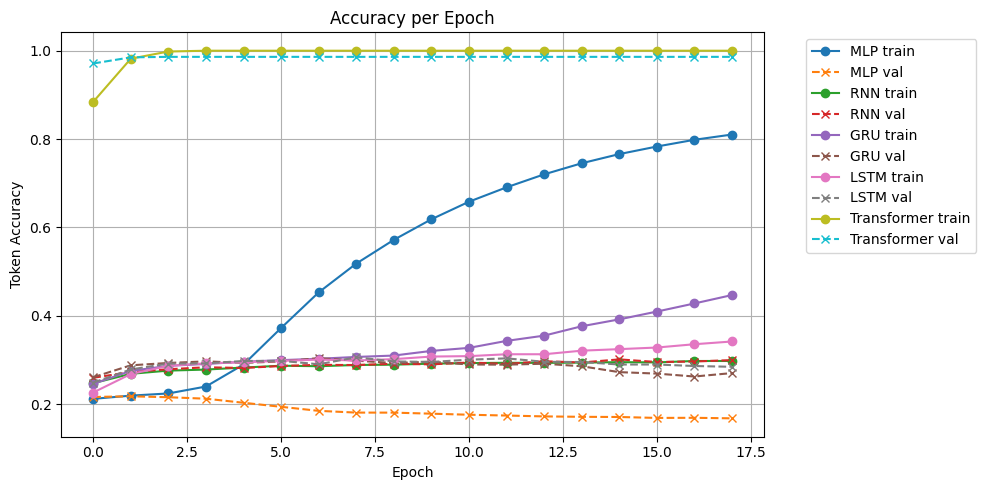

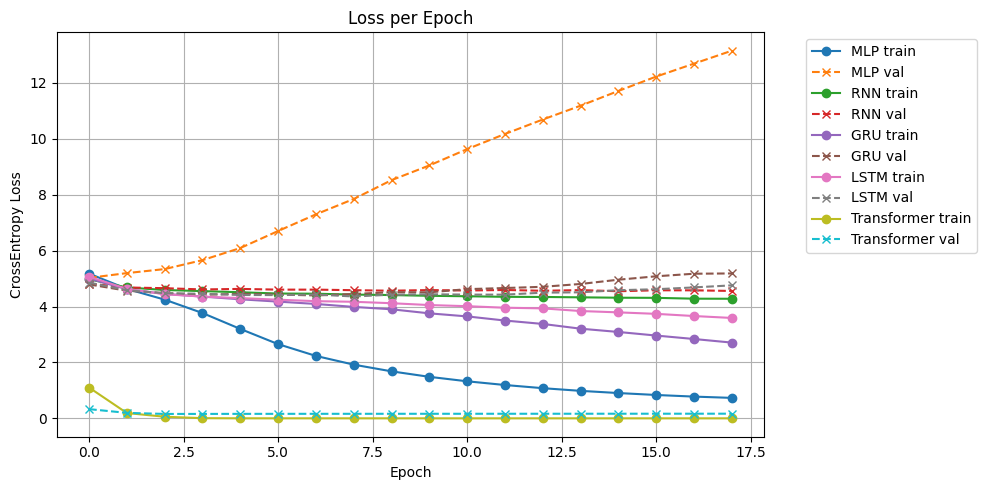

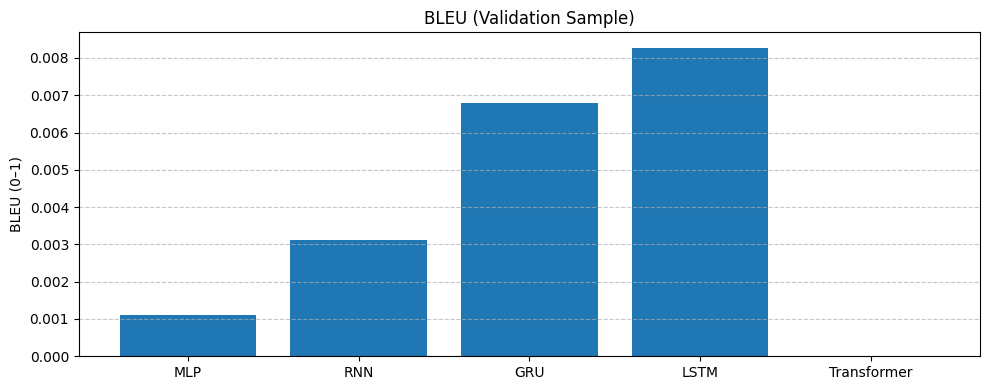

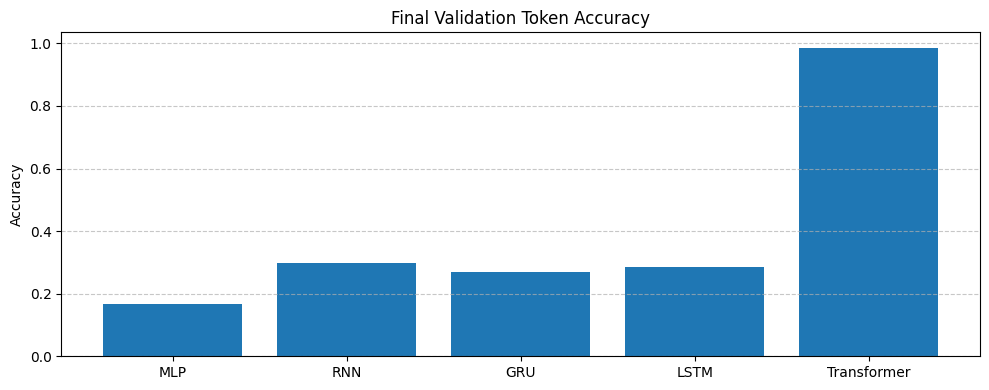


===== MODEL PERFORMANCE SUMMARY =====


,final_val_loss,final_val_acc,bleu
MLP,13.148576,0.167841,0.001113
RNN,4.556008,0.299671,0.003112
GRU,5.182472,0.270302,0.006797
LSTM,4.756174,0.284492,0.008272
Transformer,0.166305,0.986106,0.000000


In [ ]:
# =========================
# Step 8: Plot Training Curves and BLEU/Accuracy Comparison
# =========================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Accuracy per epoch ---
plt.figure(figsize=(10,5))
for name in histories.keys():
    if "train_acc" in histories[name]:
        plt.plot(histories[name]["train_acc"], marker='o', label=f"{name} train")
    if "val_acc" in histories[name]:
        plt.plot(histories[name]["val_acc"], marker='x', linestyle='--', label=f"{name} val")

plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Token Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Loss per epoch ---
plt.figure(figsize=(10,5))
for name in histories.keys():
    if "train_loss" in histories[name]:
        plt.plot(histories[name]["train_loss"], marker='o', label=f"{name} train")
    if "val_loss" in histories[name]:
        plt.plot(histories[name]["val_loss"], marker='x', linestyle='--', label=f"{name} val")

plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Bar chart: BLEU (validation sample) ---
names = list(metrics.keys())
bleu_vals = [metrics[n]["bleu"] for n in names]
val_accs = [metrics[n]["final_val_acc"] for n in names]

plt.figure(figsize=(10,4))
bars = plt.bar(names, bleu_vals)
plt.title("BLEU (Validation Sample)")
plt.ylabel("BLEU (0–1)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Bar chart: Final Validation Accuracy ---
plt.figure(figsize=(10,4))
bars = plt.bar(names, val_accs)
plt.title("Final Validation Token Accuracy")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Optional: Combine into one summary table (for report) ---
results_df = pd.DataFrame(metrics).T
print("\n===== MODEL PERFORMANCE SUMMARY =====")
display(results_df)


In [ ]:
# Step 9 — pick best model (by BLEU then val_acc) and chat
best_name = max(metrics.keys(), key=lambda n: (metrics[n]["bleu"], metrics[n]["final_val_acc"]))
best_model = models[best_name]
print("Best model chosen:", best_name)
print("Metrics:", metrics[best_name])

def chat_loop(model, model_name):
    print(f"Chat with model: {model_name} — type 'quit' to stop.")
    while True:
        u = input("You: ").strip()
        if u.lower() in ("quit","exit"):
            print("Ending chat.")
            break
        reply = generate_reply(model, model_name, u)
        print("Bot:", reply)

# Run the interactive chat loop:
chat_loop(best_model, best_name)


Best model chosen: LSTM
Metrics: {'final_val_loss': 4.75617364112367, 'final_val_acc': 0.2844923779051355, 'bleu': 0.008272428277446921}
Chat with model: LSTM — type 'quit' to stop.
You: Hi
Bot: what ?
You: What is your name?
Bot: i .
You: quit
Ending chat.


In [ ]:
SAVE_DIR = Path("saved_models")
SAVE_DIR.mkdir(exist_ok=True)
torch.save(best_model.state_dict(), SAVE_DIR / f"best_model_{best_name}.pt")
with open(SAVE_DIR / "vocab.json", "w") as f:
    import json
    json.dump({"word2idx": word2idx, "idx2word": idx2word}, f)
print("Saved best model and vocab to", SAVE_DIR)


Saved best model and vocab to saved_models
